In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from urllib.request import urlopen

from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


import xgboost as xgb

In [ ]:
yearsTypeA = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

yearMap={'2010' : 2010, '2011':2011,'2012': 2012, '2013':2013, '2014':2014, '2015':2015, '2016':2016, '2017':2017, '2018':2018, '2019':2019,
         '2006-2010':2010, '2007-2011':2011, '2008-2012':2012, '2009-2013':2013, '2010-2014':2014, '2011-2015':2015, '2012-2016':2016, '2013-2017':2017, '2014-2018':2018, '2015-2019':2019, 
         '2009-2010':2010, '2010-2011':2011, '2011-2012':2012, '2012-2013':2013, '2013-2014':2014, '2014-2015':2015, '2015-2016':2016, '2016-2017':2017, '2017-2018':2018, '2018-2019':2019,
         'SFY 2009-2010':2010, 'SFY 2010-2011':2011, 'SFY 2011-2012':2012, 'SFY 2012-2013':2013, 'SFY 2013-2014':2014, 'SFY 2014-2015':2015, 'SFY 2015-2016':2016, 'SFY 2016-2017':2017, 'SFY 2017-2018':2018, 'SFY 2018-2019':2019}

yearsTypeX = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

yearsTypeB = ['2006-2010', '2007-2011', '2008-2012', '2009-2013', '2010-2014', '2011-2015', '2012-2016', '2013-2017', '2014-2018', '2015-2019']

yearsTypeC = ['2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019']

yearsTypeD = ['SFY 2009-2010', 'SFY 2010-2011', 'SFY 2011-2012', 'SFY 2012-2013', 'SFY 2013-2014', 'SFY 2014-2015', 'SFY 2015-2016', 'SFY 2016-2017', 'SFY 2017-2018', 'SFY 2018-2019']


# Function to make data filtering easier
def filter_data(dataF, column, value):
  dataF = dataF[dataF[column] == value]
  return dataF

# Automatically indexes by column 
def read(url):
  df=pd.read_csv(url, index_col=['Town'])
  df.replace(yearMap, inplace=True)
  df = df[df['Year'].isin(yearsTypeX)]
  df['Year'] = df['Year'].astype(int)
  df=df.set_index('Year', append=True)
  if ('Race/Ethnicity' in df):
    df=df[df['Race/Ethnicity'] == 'All']
  if ('FIPS' in df): 
    df=df.drop(columns=['FIPS'])
  return df

def readM(url):
  df=pd.read_csv(url, index_col=['Town'])
  df=df[df['Variable'] != 'Margins of Error']
  df=df[df['Measure Type'] == 'Number']
  df.replace(yearMap, inplace=True)
  df = df[df['Year'].isin(yearsTypeX)]
  df['Year'] = df['Year'].astype(int)
  df=df.set_index('Year', append=True)
  if ('Race/Ethnicity' in df):
    df=df[df['Race/Ethnicity'] == 'All']
  if ('FIPS' in df): 
    df=df.drop(columns=['FIPS'])
  return df


# Moody's rating years 2000 to 2018
url_moodys = "https://raw.githubusercontent.com/CT-Data-Collaborative/moodys-rating/master/data/moodys_ratings_2018.csv"
bondrating=read(url_moodys)
ratings=['Aaa', 'Aa1', 'Aa2','Aa3', 'A1', 'A2', 'A3', 'Baa1', 'Baa2', 'Baa3', 'Ba1', 'Ba2', 'Ba3', 'B1', 'B2', 'B3', 'Caa1', 'Caa2', 'Caa3', 'Ca']
# Probability of a default based on rating
pdefault=[0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.13, 0.18, 0.3, 0.45, 0.7, 1, 1.45, 2, 5, 9, 14, 15, 16, 17]
bondrating['DefaultProb']=np.nan
for i in range(len(ratings)):
  bondrating.loc[(bondrating['Value'].str.contains(ratings[i], na=False)), 'DefaultProb'] = pdefault[i]

townget=pd.read_csv(url_moodys, index_col='Town')
towns=townget.index.unique()
# yr=[]
# for i in range(len(towns)):
#   yr[i]=2019



# Town-level social security data
url_ct_ssi="https://raw.githubusercontent.com/CT-Data-Collaborative/social-security-status/master/data/social-security-status-2019.csv"
ssi=readM(url_ct_ssi)
ssi=filter_data(ssi, 'Social Security Status', 'With SSI')


# 4 Year Graduation Rates by year and race 
url_grad="https://raw.githubusercontent.com/CT-Data-Collaborative/four-year-grad-rates-by-race-ethnicity/master/data/four_year_grad_rate_by_race_ethnicity_2011-2019.csv"
grad=pd.read_csv(url_grad)
grad['Town']=np.nan
grad=filter_data(grad, 'Variable', 'Four Year Graduation Rate')
for town in towns:
  grad.loc[grad['District'].str.contains(town, na=False), 'Town'] = town
grad.replace(yearMap, inplace=True)
grad['Year'] = grad['Year'].astype(int)
grad = grad[grad['Year'].isin(yearsTypeX)]
grad = grad[grad['Town'].isin(towns)]
grad=grad.set_index(['Town', 'Year'])



# Unemployment data
url_employ="https://raw.githubusercontent.com/CT-Data-Collaborative/labor-force/master/data/labor_force_2005-2020.csv"
employ=pd.read_csv(url_employ, index_col=['Town/County', 'Year'])
employ=filter_data(employ, 'Month','Annual Average')
employ=filter_data(employ, 'Measure', 'Unemployment')
employ=employ.index.rename(['Town', 'Year'])
# employ=employ[employ['Month'] == 'Annual Average']
# employ=employ[employ['Measure'] == 'Unemployment']
# employ=filter_data(employ, 'Month','Annual Average')
# employ=filter_data(employ, 'Measure', 'Unemployment')


# Population data
url_pop="https://raw.githubusercontent.com/CT-Data-Collaborative/dph-annual-population-estimates-by-town/master/data/dph-population-by-town_2019.csv"
pop=read(url_pop)
pop=filter_data(pop, 'Measure Type', 'Number')


# Public vs Private school enrollment
url_schooltype = "https://raw.githubusercontent.com/CT-Data-Collaborative/public-vs-private-enrollment-by-town/master/data/public-vs-private-enrollment-town-2019.csv"
schooltype=readM(url_schooltype)

# SNAP receipients
url_snap = "https://raw.githubusercontent.com/CT-Data-Collaborative/snap-recipients-by-town/master/data/snap-recipients-by-town-2019.csv"
snap=readM(url_snap)

# Disengaged Youth 
url_youth = "https://raw.githubusercontent.com/CT-Data-Collaborative/disengaged-youth/master/data/disengaged-youth-2019.csv"
youth = readM(url_youth)
youth=filter_data(youth, 'Engagement', 'Disengaged')

# English proficiency by age
url_english="https://raw.githubusercontent.com/CT-Data-Collaborative/english-proficiency-by-age/master/data/english-proficiency-by-age-2019.csv"
english=readM(url_english)

# Children by family type
url_family="https://raw.githubusercontent.com/CT-Data-Collaborative/children-by-family-type/master/data/children_by_family_type-2019.csv"
family=readM(url_family)

# Cost burdened household
url_burder="https://raw.githubusercontent.com/CT-Data-Collaborative/cost-burdened-households-by-town/master/data/cost-burdened-households-town-2019.csv"
costburden=readM(url_burder)

# Median Rent
url_rent="https://raw.githubusercontent.com/CT-Data-Collaborative/median-rent-by-town/master/data/median-rent-town-2019.csv"
rent=readM(url_rent)

# Median home value
url_homeval="https://raw.githubusercontent.com/CT-Data-Collaborative/median-home-value-by-town/master/data/median-home-value-town-2019.csv"
homeval=readM(url_homeval)

# Land area by town (for density calc)
url_land="https://raw.githubusercontent.com/CT-Data-Collaborative/land-area-by-town/main/landareabytown.csv"
land=pd.read_csv(url_land)
land=filter_data(land, 'Year', 2010)
land = land[land['Town'].isin(towns)]
land=land.set_index('Town')

# Subsidized housing by type
# url_subsidized="https://raw.githubusercontent.com/CT-Data-Collaborative/subsidized-housing-by-type/master/data/subsidized-housing-by-type_2019.csv"
# subsidized=pd.read_csv(url_subsidized, usecols=["Town", 'Year', 'Value'], names=['Town', 'Year', 'Value'])
# subsidized.replace(yearMap, inplace=True)
# subsidized['Year'] = subsidized['Year'].astype(int)
# subsidized = subsidized[subsidized['Year'].isin(yearsTypeX)]
# subsidized = subsidized.set_index(['Town', 'Year'])

# Prescriber Info
url_prescriber="https://raw.githubusercontent.com/menzicode/project_code/main/inputs/prescriber-info.csv"

# Town-level educational attainment data
url_edu="https://raw.githubusercontent.com/CT-Data-Collaborative/educational-attainment/master/data/educational_attainment_2019.csv"
edu=readM(url_edu)

# Health insurenace coverage
url_healthinsurance="https://raw.githubusercontent.com/CT-Data-Collaborative/health-insurance-coverage/master/data/health-insurance-coverage-2019.csv"
insurance=readM(url_healthinsurance)

# Poverty rate
url_poverty="https://raw.githubusercontent.com/CT-Data-Collaborative/poverty-status-by-town/master/data/poverty-status-by-town-2019.csv"
poverty=readM(url_poverty)
poverty=filter_data(poverty, 'Poverty Status', 'Below Poverty Level')

# DUI Crashes last 10 years
url_dui_crashes="https://raw.githubusercontent.com/CT-Data-Collaborative/dui-crashes/master/data/dui-crashes-2019.csv"
dui_crashes=read(url_dui_crashes)
dui_crashes=filter_data(dui_crashes, 'Variable', 'DUI Crashes')

# Median Age by Town
url_age="https://raw.githubusercontent.com/CT-Data-Collaborative/median-age-by-town/master/data/median_age_town_2019.csv"
age=readM(url_age)

# Mental health and substance abuse admission by town
url_admissions="https://raw.githubusercontent.com/CT-Data-Collaborative/mental-health-and-substance-abuse-treatment-admissions/master/data/dmhas_admissions_2018.csv"
admissions=readM(url_admissions)

# DUI arrests 
url_dui_arrest="https://raw.githubusercontent.com/CT-Data-Collaborative/dui-arrests/master/data/dui-arrests_2016.csv"
dui_arrest=readM(url_dui_arrest)
dui_arrest=dui_arrest=filter_data(dui_arrest, 'Age Range', 'Total')

# Child abuse and neglect 
url_abuse="https://raw.githubusercontent.com/CT-Data-Collaborative/child-abuse-and-neglect/master/data/child_abuse_neglect_2017.csv"
abuse=readM(url_abuse)
abuse=filter_data(filter_data(abuse, 'Allegation Type', 'All'), 'Report Status', 'Alleged')


# Veteran Status
url_vet="https://raw.githubusercontent.com/CT-Data-Collaborative/veteran-status/master/data/veteran-status-2019.csv"
vet=readM(url_vet)
vet=filter_data(vet, 'Veteran Status', 'Veteran')



# https://portal.ct.gov/DCP/Prescription-Monitoring-Program/CTPMP-Statistics

# request data at:  dcp.pmp@ct.gov

In [ ]:
def filterGender(data, gender):
  df=data[data['Gender'] == gender]
  return df

def filterAge(data, age):
  df=data[data['Age'] == age]
  return df

mentalHealth=filter_data(admissions, 'Admission Type', 'Mental Health')
substanceAbuse=filter_data(admissions, 'Admission Type', 'Substance Abuse')

vetMale=filterGender(vet, 'Male')
vetFemale=filterGender(vet, 'Female')

vetYoungMale=filterAge(vetMale, '18 to 34 years')
vetYoungFemale=filterAge(vetFemale, '18 to 34 years')
vetMiddleMale=filterAge(vetMale, '35 to 54 years')
vetMiddleFemale=filterAge(vetFemale, '35 to 54 years')

ageFemale=filterGender(age, 'Female')
ageMale=filterGender(age, 'Male')

insurance=filter_data(insurance, 'Age Range', '18-64')
privateInsure=filter_data(insurance, 'Insurance Status', 'With Private Health Insurance')
publicInsure=filter_data(insurance, 'Insurance Status', 'With Public Health Insurance')
noInsure=filter_data(insurance, 'Insurance Status', 'Without Health Insurance')

edu_male=filterGender(edu, 'Male')
edu_female=filterGender(edu, 'Female')
maleHSless=filter_data(edu_male, 'Educational Attainment', 'Less than High School Diploma')
maleHS=filter_data(edu_male, 'Educational Attainment', 'High School Diploma, GED, or equivalent')
maleSomeC=filter_data(edu_male, 'Educational Attainment', 'Some College')
maleBach=filter_data(edu_male, 'Educational Attainment', "Bachelor's Degree or higher")
maleAssoc=filter_data(edu_male, 'Educational Attainment', "Associate's Degree")
femaleHSless=filter_data(edu_female, 'Educational Attainment', 'Less than High School Diploma')
femaleHS=filter_data(edu_female, 'Educational Attainment', 'High School Diploma, GED, or equivalent')
femaleSomeC=filter_data(edu_female, 'Educational Attainment', 'Some College')
femaleBach=filter_data(edu_female, 'Educational Attainment', "Bachelor's Degree or higher")
femaleAssoc=filter_data(edu_female, 'Educational Attainment', "Associate's Degree")

costburdenHO=filter_data(costburden, 'Householder Status', 'Homeowner')
costburdenRenter=filter_data(costburden, 'Householder Status', 'Renter')

familyMarried=filter_data(family, 'Family Type', 'Married-couple Family')
familySingle=filter_data(family, 'Family Type', 'Single-parent Family')
fmU3=filter_data(familyMarried, 'Age of Child', 'Under 3 years')
fm34=filter_data(familyMarried, 'Age of Child', '3 to 4 years')
fm5=filter_data(familyMarried, 'Age of Child', '5 years')
fm611=filter_data(familyMarried, 'Age of Child', '6 to 11 years')
fm1217=filter_data(familyMarried, 'Age of Child', '12 to 17 years')
fsU3=filter_data(familySingle, 'Age of Child', 'Under 3 years')
fs34=filter_data(familySingle, 'Age of Child', '3 to 4 years')
fs5=filter_data(familySingle, 'Age of Child', '5 years')
fs611=filter_data(familySingle, 'Age of Child', '6 to 11 years')
fs1217=filter_data(familySingle, 'Age of Child', '12 to 17 years')

english=filter_data(english, 'Age', 'Total')
englishNA=filter_data(english, 'English Proficiency', 'Not at All')
englishNW=filter_data(english, 'English Proficiency', 'Not Well')
englishVW=filter_data(english, 'English Proficiency', 'Very Well')
englishW=filter_data(english, 'English Proficiency', 'Well')

youthFemale=filterGender(youth, 'Female')
youthMale=filterGender(youth, 'Male')

public=filter_data(schooltype, 'School Type', 'Public')
private=filter_data(schooltype, 'School Type', 'Private')
publicPK=filter_data(public, 'Grade', 'Pre-K')
publicHS=filter_data(public, 'Grade', 'Grades 9 to 12')
privatePK=filter_data(private, 'Grade', 'Pre-K')
privateHS=filter_data(private, 'Grade', 'Grades 9 to 12')

gradW=filter_data(grad, "Race/Ethnicity", 'White')
gradB=filter_data(grad, "Race/Ethnicity", 'Black')
gradH=filter_data(grad, "Race/Ethnicity", 'Hispanic')
gradA=filter_data(grad, "Race/Ethnicity", 'Asian')

povChild=filter_data(poverty, 'Age', 'Under 18')
povTotal=filter_data(poverty, 'Age', 'Total')
povAdult=filter_data(poverty, 'Age', 'Total')
povAdult['Value'] = povTotal['Value'] - povChild['Value']


v='Value'
data=[mentalHealth[v], substanceAbuse[v], vetYoungMale[v], vetYoungFemale[v], vetMiddleMale[v], ageMale[v], ageFemale[v], privateInsure[v], publicInsure[v], noInsure[v],
      maleHSless[v], maleHS[v], maleSomeC[v], maleAssoc[v], maleBach[v], femaleHSless[v], femaleHS[v], femaleSomeC[v], femaleAssoc[v], femaleBach[v], costburdenHO[v], costburdenRenter[v], fsU3[v],
      fs34[v], fs5[v], fs611[v], fs1217[v], englishNA[v], englishNW[v], englishVW[v], englishW[v], youthMale[v], youthFemale[v], publicPK[v], publicHS[v], privatePK[v], privateHS[v],
      ssi[v], pop[v], snap[v], rent[v], dui_arrest[v], dui_crashes[v], abuse[v], bondrating['DefaultProb'], povChild[v], povAdult[v]]


#, 'Subsidized Housing'

keys=['Mental Health', 'Substance Abuse', 'YM Veteran', 'YF Veteran', 'MAM Veteran', 'Age Male', 'Age Female', 'Private Insurance', 'Public Insurance', 'No Insurance', 'Male <HS', 
      'Male HS', 'Male Some Col', 'Male Associates', 'Male Bach+','Female <HS', 'Female HS', 'Female Some Col', 'Female Associates', 'Female Bach+', 'Cost Burdened HO', 'Cost Burdened Renter','SingleParent <3 YO',
      'SP 3-4YO', 'SP 5YO', 'SP 6-11YO', 'SP 12-17YO', 'English: None', 'Eng: Not Well', 'Eng: Very Well', 'Eng: Well', 'Disengaged Youth M', 'Disengaged Youth F', 'Public PK Enrol', 'Public HS Enrol', 'Private PK enrol',
      'Private HS enrol', 'On Social Security', 'Population', 'Receiving SNAP', 'Avg Rent', 'Dui Arrests', 'Dui Crashes', 'Abuse Allegations', 'Bond Default Prob', 'Child Poverty', 'Adult Poverty']

m=pd.concat(data, keys=keys, axis=1, levels=2, join='outer')
m.head(1500)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Mental Health  Substance Abuse  ...  Child Poverty  Adult Poverty
Town      Year                                  ...                              
Andover   2012           29.0             27.0  ...           56.0          100.0
          2013           30.0             26.0  ...           56.0           78.0
          2014           41.0             22.0  ...           51.0           66.0
          2015           44.0             21.0  ...           56.0           28.0
          2016           29.0             27.0  ...            0.0           17.0
...                       ...              ...  ...            ...            ...
Woodstock 2015           88.0             44.0  ...           62.0          202.0
          2016           75.0             51.0  ...           45.0          184.0
          2017           79.0             49.0  ...          145.0          321.0
          2018           60.0             54.0  ...          114.0          233.0
          2019            NaN              NaN  ...          126.0          317.0

[1360 rows x 47 columns]

In [ ]:
bondrating.head(2000)

,,Measure Type,Variable,Value,DefaultProb
Town,Year,,,,
Andover,2012,Moody's Rating,Moody's Rating,NaN,NaN
Ansonia,2012,Moody's Rating,Moody's Rating,Aa3,0.05
Ashford,2012,Moody's Rating,Moody's Rating,Aa3,0.05
Avon,2012,Moody's Rating,Moody's Rating,Aaa,0.02
Barkhamsted,2012,Moody's Rating,Moody's Rating,NaN,NaN
...,...,...,...,...,...
Windsor Locks,2018,Moody's Rating,Moody's Rating,Aa1,0.03
Wolcott,2018,Moody's Rating,Moody's Rating,A1,0.07
Woodbridge,2018,Moody's Rating,Moody's Rating,Aaa,0.02


In [ ]:
ssi.head()

Social Security Status Measure Type                Variable  Value
Town    Year                                                                   
Andover 2012               With SSI       Number  Social Security Status  255.0
        2013               With SSI       Number  Social Security Status  305.0
        2014               With SSI       Number  Social Security Status  307.0
        2015               With SSI       Number  Social Security Status  354.0
        2016               With SSI       Number  Social Security Status  318.0

In [ ]:
grad.head(100)

District  ...  Value
Town       Year                                                 ...       
Bridgeport 2015  Achievement First Bridgeport Academy District  ...  100.0
Ansonia    2018                        Ansonia School District  ...  100.0
Avon       2012                           Avon School District  ...  100.0
           2012                           Avon School District  ...  100.0
           2013                           Avon School District  ...  100.0
...                                                        ...  ...    ...
Groton     2012                         Groton School District  ...  100.0
Guilford   2012                       Guilford School District  ...  100.0
           2012                       Guilford School District  ...  100.0
           2014                       Guilford School District  ...  100.0
           2014                       Guilford School District  ...  100.0

[100 rows x 6 columns]

In [ ]:
# employ.head()

In [ ]:
pop.head()

Measure Type              Variable   Value
Town    Year                                           
Andover 2012       Number  Estimated Population  3272.0
        2013       Number  Estimated Population  3273.0
        2014       Number  Estimated Population  3272.0
        2015       Number  Estimated Population  3262.0
        2016       Number  Estimated Population  3252.0

In [ ]:
schooltype.head()

Grade School Type Measure Type           Variable  Value
Town    Year                                                          
Andover 2012  Total       Total       Number  Enrolled Students  691.0
        2012  Total      Public       Number  Enrolled Students  673.0
        2012  Total     Private       Number  Enrolled Students   18.0
        2012  Pre-K       Total       Number  Enrolled Students   30.0
        2012  Pre-K      Public       Number  Enrolled Students   20.0

In [ ]:
snap.head()

Race/Ethnicity Measure Type         Variable  Value
Town    Year                                                    
Andover 2012            All       Number  SNAP Recipients    7.0
        2013            All       Number  SNAP Recipients    6.0
        2014            All       Number  SNAP Recipients   13.0
        2015            All       Number  SNAP Recipients   14.0
        2016            All       Number  SNAP Recipients   16.0

In [ ]:
schooltype.head(25)

Grade School Type Measure Type           Variable  Value
Town    Year                                                                   
Andover 2012           Total       Total       Number  Enrolled Students  691.0
        2012           Total      Public       Number  Enrolled Students  673.0
        2012           Total     Private       Number  Enrolled Students   18.0
        2012           Pre-K       Total       Number  Enrolled Students   30.0
        2012           Pre-K      Public       Number  Enrolled Students   20.0
        2012           Pre-K     Private       Number  Enrolled Students   10.0
        2012               K       Total       Number  Enrolled Students   20.0
        2012               K      Public       Number  Enrolled Students   20.0
        2012               K     Private       Number  Enrolled Students    0.0
        2012   Grades 1 to 4       Total       Number  Enrolled Students  142.0
        2012   Grades 1 to 4      Public       Number  Enrolled Students  142.0
        2012   Grades 1 to 4     Private       Number  Enrolled Students    0.0
        2012   Grades 5 to 8       Total       Number  Enrolled Students  154.0
        2012   Grades 5 to 8      Public       Number  Enrolled Students  154.0
        2012   Grades 5 to 8     Private       Number  Enrolled Students    0.0
        2012  Grades 9 to 12       Total       Number  Enrolled Students  345.0
        2012  Grades 9 to 12      Public       Number  Enrolled Students  337.0
        2012  Grades 9 to 12     Private       Number  Enrolled Students    8.0
        2013           Total       Total       Number  Enrolled Students  657.0
        2013           Total      Public       Number  Enrolled Students  602.0
        2013           Total     Private       Number  Enrolled Students   55.0
        2013           Pre-K       Total       Number  Enrolled Students   24.0
        2013           Pre-K      Public       Number  Enrolled Students   24.0
        2013           Pre-K     Private       Number  Enrolled Students    0.0
        2013               K       Total       Number  Enrolled Students   27.0

In [ ]:
youth.head()

Gender  Engagement Measure Type          Variable  Value
Town    Year                                                          
Andover 2012   Total  Disengaged       Number  Disengaged Youth    0.0
        2012  Female  Disengaged       Number  Disengaged Youth    0.0
        2012    Male  Disengaged       Number  Disengaged Youth    0.0
        2013   Total  Disengaged       Number  Disengaged Youth    9.0
        2013  Female  Disengaged       Number  Disengaged Youth    0.0

In [ ]:
english.head(25)

English Proficiency    Age  ...             Variable   Value
Town    Year                             ...                             
Andover 2012              Native  Total  ...  English Proficiency  2742.0
        2012          Not at All  Total  ...  English Proficiency     0.0
        2012            Not Well  Total  ...  English Proficiency     9.0
        2012           Very Well  Total  ...  English Proficiency   255.0
        2012                Well  Total  ...  English Proficiency    23.0
        2013              Native  Total  ...  English Proficiency  2655.0
        2013          Not at All  Total  ...  English Proficiency     0.0
        2013            Not Well  Total  ...  English Proficiency     9.0
        2013           Very Well  Total  ...  English Proficiency   242.0
        2013                Well  Total  ...  English Proficiency    11.0
        2014              Native  Total  ...  English Proficiency  2690.0
        2014          Not at All  Total  ...  English Proficiency     0.0
        2014            Not Well  Total  ...  English Proficiency    12.0
        2014           Very Well  Total  ...  English Proficiency   298.0
        2014                Well  Total  ...  English Proficiency     8.0
        2015              Native  Total  ...  English Proficiency  2834.0
        2015          Not at All  Total  ...  English Proficiency     0.0
        2015            Not Well  Total  ...  English Proficiency     0.0
        2015           Very Well  Total  ...  English Proficiency   234.0
        2015                Well  Total  ...  English Proficiency    12.0
        2016              Native  Total  ...  English Proficiency  2888.0
        2016          Not at All  Total  ...  English Proficiency     0.0
        2016            Not Well  Total  ...  English Proficiency     0.0
        2016           Very Well  Total  ...  English Proficiency   194.0
        2016                Well  Total  ...  English Proficiency    11.0

[25 rows x 5 columns]

In [ ]:
family.head(25)

Family Type  ...  Value
Town    Year                                       ...       
Andover 2012                Married-couple Family  ...  547.0
        2012                Married-couple Family  ...   78.0
        2012                Married-couple Family  ...   39.0
        2012                Married-couple Family  ...   20.0
        2012                Married-couple Family  ...  166.0
        2012                Married-couple Family  ...  244.0
        2012   Single-parent Familiy, Male Parent  ...   50.0
        2012   Single-parent Familiy, Male Parent  ...    0.0
        2012   Single-parent Familiy, Male Parent  ...    0.0
        2012   Single-parent Familiy, Male Parent  ...    0.0
        2012   Single-parent Familiy, Male Parent  ...    0.0
        2012   Single-parent Familiy, Male Parent  ...   50.0
        2012                 Single-parent Family  ...  196.0
        2012                 Single-parent Family  ...   33.0
        2012                 Single-parent Family  ...    0.0
        2012                 Single-parent Family  ...    0.0
        2012                 Single-parent Family  ...   56.0
        2012                 Single-parent Family  ...  107.0
        2012  Single-parent Family, Female Parent  ...  146.0
        2012  Single-parent Family, Female Parent  ...   33.0
        2012  Single-parent Family, Female Parent  ...    0.0
        2012  Single-parent Family, Female Parent  ...    0.0
        2012  Single-parent Family, Female Parent  ...   56.0
        2012  Single-parent Family, Female Parent  ...   57.0
        2012                                Total  ...  743.0

[25 rows x 5 columns]

In [ ]:
costburden.head()

Householder Status Measure Type                  Variable  Value
Town    Year                                                                 
Andover 2012                All       Number  Cost-burdened Households  278.0
        2012          Homeowner       Number  Cost-burdened Households  210.0
        2012             Renter       Number  Cost-burdened Households   68.0
        2013                All       Number  Cost-burdened Households  269.0
        2013          Homeowner       Number  Cost-burdened Households  208.0

In [ ]:
rent.head(50)

Measure Type     Variable   Value
Town         Year                                  
Andover      2012       Number  Median Rent   792.0
             2013       Number  Median Rent   793.0
             2014       Number  Median Rent   850.0
             2015       Number  Median Rent   807.0
             2016       Number  Median Rent   804.0
             2017       Number  Median Rent   840.0
             2018       Number  Median Rent   831.0
             2019       Number  Median Rent   821.0
Ansonia      2012       Number  Median Rent  1105.0
             2013       Number  Median Rent  1068.0
             2014       Number  Median Rent  1082.0
             2015       Number  Median Rent  1057.0
             2016       Number  Median Rent  1031.0
             2017       Number  Median Rent  1026.0
             2018       Number  Median Rent  1047.0
             2019       Number  Median Rent  1101.0
Ashford      2012       Number  Median Rent  1016.0
             2013       Number  Median Rent   944.0
             2014       Number  Median Rent   886.0
             2015       Number  Median Rent   850.0
             2016       Number  Median Rent   876.0
             2017       Number  Median Rent   920.0
             2018       Number  Median Rent   951.0
             2019       Number  Median Rent   975.0
Avon         2012       Number  Median Rent  1356.0
             2013       Number  Median Rent  1268.0
             2014       Number  Median Rent  1253.0
             2015       Number  Median Rent  1234.0
             2016       Number  Median Rent  1310.0
             2017       Number  Median Rent  1404.0
             2018       Number  Median Rent  1413.0
             2019       Number  Median Rent  1426.0
Barkhamsted  2012       Number  Median Rent   893.0
             2013       Number  Median Rent   889.0
             2014       Number  Median Rent   896.0
             2015       Number  Median Rent   997.0
             2016       Number  Median Rent  1102.0
             2017       Number  Median Rent  1121.0
             2018       Number  Median Rent  1444.0
             2019       Number  Median Rent  1422.0
Beacon Falls 2012       Number  Median Rent  1147.0
             2013       Number  Median Rent  1095.0
             2014       Number  Median Rent  1191.0
             2015       Number  Median Rent  1205.0
             2016       Number  Median Rent  1147.0
             2017       Number  Median Rent  1225.0
             2018       Number  Median Rent  1294.0
             2019       Number  Median Rent  1364.0
Berlin       2012       Number  Median Rent  1019.0
             2013       Number  Median Rent  1033.0

In [ ]:
land.head()

,FIPS,Year,Measure Type,Variable,Value
Town,,,,,
Bethel,900104720,2010,Square Miles,Land Area,16.89
Bridgeport,900108070,2010,Square Miles,Land Area,15.97
Brookfield,900108980,2010,Square Miles,Land Area,19.77
Danbury,900118500,2010,Square Miles,Land Area,41.89
Darien,900118850,2010,Square Miles,Land Area,12.66


In [ ]:
homeval.head()

Measure Type           Variable     Value
Town    Year                                          
Andover 2012       Number  Median Home Value  302500.0
        2013       Number  Median Home Value  287200.0
        2014       Number  Median Home Value  303200.0
        2015       Number  Median Home Value  276200.0
        2016       Number  Median Home Value  281700.0

In [ ]:
# subsidized.head()

In [ ]:
edu.head(7)

Gender  ...   Value
Town    Year          ...        
Andover 2012  Female  ...   155.0
        2012  Female  ...   434.0
        2012  Female  ...   255.0
        2012  Female  ...    84.0
        2012  Female  ...   169.0
        2012  Female  ...  1097.0
        2012    Male  ...   159.0

[7 rows x 5 columns]

In [ ]:
insurance.head(15)

Age Range               Insurance Status  ...          Variable   Value
Town    Year                                           ...                          
Andover 2012     18-64  With Private Health Insurance  ...  Health Insurance  1821.0
        2012     18-64   With Public Health Insurance  ...  Health Insurance   134.0
        2012     18-64       Without Health Insurance  ...  Health Insurance   130.0
        2013     18-64  With Private Health Insurance  ...  Health Insurance  1705.0
        2013     18-64   With Public Health Insurance  ...  Health Insurance   195.0
        2013     18-64       Without Health Insurance  ...  Health Insurance   118.0
        2014     18-64  With Private Health Insurance  ...  Health Insurance  1761.0
        2014     18-64   With Public Health Insurance  ...  Health Insurance   195.0
        2014     18-64       Without Health Insurance  ...  Health Insurance   137.0
        2015     18-64  With Private Health Insurance  ...  Health Insurance  1788.0
        2015     18-64   With Public Health Insurance  ...  Health Insurance   176.0
        2015     18-64       Without Health Insurance  ...  Health Insurance    87.0
        2016     18-64  With Private Health Insurance  ...  Health Insurance  2014.0
        2016     18-64   With Public Health Insurance  ...  Health Insurance   181.0
        2016     18-64       Without Health Insurance  ...  Health Insurance    63.0

[15 rows x 5 columns]

In [ ]:
poverty.head()

Race/Ethnicity       Age  ...        Variable  Value
Town    Year                           ...                       
Andover 2012            All     Total  ...  Poverty Status  156.0
        2012            All  Under 18  ...  Poverty Status   56.0
        2013            All     Total  ...  Poverty Status  134.0
        2013            All  Under 18  ...  Poverty Status   56.0
        2014            All     Total  ...  Poverty Status  117.0

[5 rows x 6 columns]

In [ ]:
dui_arrest.head()

Age Range Measure Type     Variable  Value
Town    Year                                           
Andover 2012     Total       Number  DUI Arrests    7.0
        2013     Total       Number  DUI Arrests    9.0
        2014     Total       Number  DUI Arrests    4.0
        2015     Total       Number  DUI Arrests    8.0
        2016     Total       Number  DUI Arrests    3.0

In [ ]:
age.head()

Gender Race/Ethnicity Measure Type    Variable  Value
Town    Year                                                       
Andover 2012  Female            All       Number  Median Age   43.8
        2012    Male            All       Number  Median Age   40.9
        2012   Total            All       Number  Median Age   42.7
        2013  Female            All       Number  Median Age   44.2
        2013    Male            All       Number  Median Age   39.5

In [ ]:
dui_crashes.head()

Measure Type     Variable  Value
Town    Year                                 
Andover 2012       Number  DUI Crashes      1
        2013       Number  DUI Crashes      4
        2014       Number  DUI Crashes      2
        2015       Number  DUI Crashes      5
        2016       Number  DUI Crashes      0

In [ ]:
abuse.head()

Allegation Type Report Status  ...                 Variable Value
Town    Year                                ...                               
Andover 2012             All       Alleged  ...  Child Abuse and Neglect  21.0
        2013             All       Alleged  ...  Child Abuse and Neglect  35.0
        2014             All       Alleged  ...  Child Abuse and Neglect  43.0
        2015             All       Alleged  ...  Child Abuse and Neglect  49.0
        2016             All       Alleged  ...  Child Abuse and Neglect  33.0

[5 rows x 5 columns]

In [ ]:
vet.head()

Age Veteran Status  ...        Variable Value
Town    Year                                 ...                      
Andover 2012  18 to 34 years        Veteran  ...  Veteran Status   0.0
        2012  18 to 34 years        Veteran  ...  Veteran Status   0.0
        2012  18 to 34 years        Veteran  ...  Veteran Status   0.0
        2012  35 to 54 years        Veteran  ...  Veteran Status   0.0
        2012  35 to 54 years        Veteran  ...  Veteran Status  67.0

[5 rows x 6 columns]

In [ ]:
admissions.head()

Admission Type  ...   Value
Town    Year                                     ...        
Andover 2012                      Mental Health  ...    29.0
        2012  Mental Health and Substance Abuse  ... -9999.0
        2012                    Substance Abuse  ...    27.0
        2012                              Total  ...    63.0
        2013                      Mental Health  ...    30.0

[5 rows x 4 columns]

In [ ]:
def scraper(NPI):
  url="https://npiregistry.cms.hhs.gov/registry/provider-view/" + NPI
  page=urlopen(url)
  html_bytes=page.read()
  html=html_bytes.decode("utf-8")
  ind=html.find('Primary Practice Address')
  ind2=html.find('<br>', ind)
  town=html[ind2+13:ind2+43]
  return(town)

# Recursive function to get medical prescribers in the town
def townPracticeScraper(Town, providerListSoFar, resultLower, resultHigher):
  rlow=resultLower
  rhigh=resultHigher
  if(rlow==0):
    url="https://npiregistry.cms.hhs.gov/registry/search-results-table?city=" + Town.upper() + "&state=CT&country_code=US&addressType=PR&exactMatch=TRUE"
  else:
    url="https://npiregistry.cms.hhs.gov/registry/search-results-table?city=" + Town.upper() + "&state=CT&country_code=US&addressType=PR&exactMatch=TRUE&skip=" + str(resultLower-100) + "&skip=" + str(resultHigher-100)
  print(url)
  page=urlopen(url)
  html_bytes=page.read()
  html=html_bytes.decode("utf-8")
  indLowerResult=html.find("small")
  indLowerResultA=html.find('>', indLowerResult)
  indLowerResultB=html.find(' -', indLowerResultA)
  lowerNum=int(html[indLowerResultA+1:indLowerResultB])
  higherNum=int(html[indLowerResult+55:indLowerResult+63])
  indLast=0
  providerTypes=providerListSoFar
  print(len(providerTypes))
  for i in range((higherNum - lowerNum)+1):
    firstInd=html.find('<td style="white-space: nowrap"><div title="', indLast)+44
    lastInd=html.find('"', firstInd)
    indLast=lastInd
    provType=html[firstInd:lastInd]
    providerTypes.append(provType)
  if(html.find('<td style="white-space: nowrap"><div title="') > 0):
    return townPracticeScraper(Town, providerTypes, rlow+100, rhigh+100)
  else:
    return providerTypes


def getTownPractices(town):
  return townPracticeScraper(town, [], 0, 100)

# hart=getTownPractices("Hartford")



In [ ]:
# CT Drug death data 
url_ct_deaths="https://raw.githubusercontent.com/menzicode/project_code/main/inputs/CT_Accidental_Drug_Related_Deaths_2012-2020_raw.csv"

# Load drug overdose death data
ct_deaths=pd.read_csv(url_ct_deaths, usecols=['Date', 'Age', 'Sex', 'Race', 'Residence City', 'Residence County', 'Injury City', 'Residence State', 'Death City', 'Death County', 'Heroin', 'Cocaine', 'Fentanyl', 'Fentanyl Analogue'
                                              , 'Oxycodone', 'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Amphet', 'Tramad', 'Morphine (Not Heroin)', 'Hydromorphone', 'Xylazine', 'Opiate NOS', 
                                              'Any Opioid', 'Other'])

# Convert date to date object and city names to Title case string
ct_deaths['Residence City'] = ct_deaths['Residence City'].str.title()
ct_deaths['Death City'] = ct_deaths['Death City'].str.title()
ct_deaths['Injury City'] = ct_deaths['Injury City'].str.title()
ct_deaths['Other'] = ct_deaths['Other'].str.lower()


# Account for "Other" data 
ct_deaths['Bupren'] = np.nan
ct_deaths['Other Prescription'] = np.nan
ct_deaths.loc[(ct_deaths['Other'].str.contains('bup', na=False)), 'Bupren'] = 'Y'
ct_deaths.loc[(ct_deaths['Other'].str.contains('morph', na=False)), 'Morphine'] = 'Y'
ct_deaths.loc[(ct_deaths['Other'].str.contains('hyd', na=False)), 'Hydromorphone'] = 'Y'
ct_deaths.loc[(ct_deaths['Other'].str.contains('h-morph', na=False)), 'Hydromorphone'] = 'Y'
ct_deaths.loc[(ct_deaths['Other'].str.contains('mepe', na=False)), 'Other Prescription'] = 'Y'
ct_deaths.loc[(ct_deaths['Other'].str.contains('tape', na=False)), 'Other Prescription'] = 'Y'
ct_deaths.loc[(ct_deaths['Other'].str.contains('codeine', na=False)), 'Other Prescription'] = 'Y'
ct_deaths.loc[(ct_deaths['Other'].str.contains('tape', na=False)), 'Other Prescription'] = 'Y'
ct_deaths.loc[(ct_deaths['Other'].str.contains('opi', na=False)), 'Any Opioid'] = 'Y'

# Fix town names
cities=ct_deaths.loc[ct_deaths['Death City'].isna() == False]['Death City'].unique()
unaccounted=[]
counted=towns
for city in cities:
  if city not in towns:
    unaccounted.append(city)
unaccounted.sort()
unaccounted=unaccounted[1:]

replaced_name=['Hebron', 'New Hartford', 'Sprague', 'Litchfield', 'East Windsor', 'Plainfield', 'Cornwall', 'Greenwich', 'Killingly', 'Killingly', 'North Canaan', 'Hartland', 'Woodstock', 'Ledyard', 'Groton', 'Sprague', 'Haddam', 
               'Essex', 'Griswold', 'Berlin', 'Ledyard', 'East Haddam', 'Plainfield', 'Stonington', 'New Haven', 'New Canaan', 'Washington', 'East Lyme', 'North Haven', 'Granby', 'Thompson', 'Windham', 'Windham', 'North Branford', 
               'Montville', 'Watertown', 'Stonington', 'Sterling', 'Stonington', 'Southington', 'Waterford', 'Thompson', 'Greenwich', 'Vernon', 'Killingly', 'Glastonbury', 'Newtown', 'Windham', 'Stafford', 'Stafford', 'Mansfield', 
               'Norwich', 'Simsbury', 'Plymouth', 'Montville', 'Farmington', 'Vernon', 'West Haven', 'Plainfield', 'Simsbury', 'Cornwall', 'Stafford', 'Suffield', 'Windham', 'Windham', 'Winchester']

for i in range(66):
  ct_deaths.loc[ct_deaths['Death City'] == unaccounted[i]] = replaced_name[i]

 # df = df[df['Year'].isin(yearsTypeX)]

ct_deaths=ct_deaths[ct_deaths['Death City'].isin(towns)]


# Filter to opioid-related deaths
ct_deaths = ct_deaths.loc[(ct_deaths['Any Opioid'] == 'Y') | (ct_deaths['Heroin'] == 'Y') | (ct_deaths['Fentanyl'] == 'Y') | (ct_deaths['Fentanyl Analogue'] == 'Y') | (ct_deaths['Oxycodone'] == 'Y') 
                          | (ct_deaths['Oxymorphone'] == 'Y') | (ct_deaths['Hydrocodone'] == 'Y') | (ct_deaths['Methadone'] == 'Y') | (ct_deaths['Tramad'] == 'Y') | (ct_deaths['Morphine (Not Heroin)'] == 'Y') 
                          | (ct_deaths['Hydromorphone'] == 'Y') | (ct_deaths['Opiate NOS'] == 'Y') | (ct_deaths['Bupren'] == 'Y') | (ct_deaths['Other Prescription'] == 'Y')]


# Generate counts by year
ct_deaths['Date'] = pd.to_datetime(ct_deaths['Date'], yearfirst=True)

def filter_year(dataF, year):
  data_filt=dataF[dataF['Date'].dt.year == year]
  return data_filt

def filterDeaths(year):
  death = pd.DataFrame.from_dict(filter_year(ct_deaths, year)['Death City'].value_counts())
  death=death.rename_axis('Town')
  death=death.rename({'Death City' : 'Deaths'}, axis=1)
  yearL=[]
  for i in range(len(death)):
    yearL.append(year)
  death['Year']=yearL
  death=death.set_index('Year', append=True)
  return death


# townDataDeaths=townData
deathCity = ct_deaths['Death City'].value_counts()
resDeaths = ct_deaths['Residence City'].value_counts()
injuryCity = ct_deaths['Injury City'].value_counts()


d12=filterDeaths(2012)
d13=filterDeaths(2013)
d14=filterDeaths(2014)
d15=filterDeaths(2015)
d16=filterDeaths(2016)
d17=filterDeaths(2017)
d18=filterDeaths(2018)
d19=filterDeaths(2019)
d20=filterDeaths(2020)

a = pd.concat((d12, d13, d14, d15, d16, d17, d18, d19))

data=[mentalHealth[v], substanceAbuse[v], vetYoungMale[v], vetYoungFemale[v], vetMiddleMale[v], ageMale[v], ageFemale[v], privateInsure[v], publicInsure[v], noInsure[v],
      maleHSless[v], maleHS[v], maleSomeC[v], maleAssoc[v], maleBach[v], femaleHSless[v], femaleHS[v], femaleSomeC[v], femaleAssoc[v], femaleBach[v], costburdenHO[v], costburdenRenter[v], fsU3[v],
      fs34[v], fs5[v], fs611[v], fs1217[v], englishNA[v], englishNW[v], englishVW[v], englishW[v], youthMale[v], youthFemale[v], publicPK[v], publicHS[v], privatePK[v], privateHS[v],
      ssi[v], snap[v], pop[v], rent[v], dui_arrest[v], dui_crashes[v], abuse[v], bondrating['DefaultProb'], povChild[v], povAdult[v], a['Deaths']]



#, 'Subsidized Housing'

keys=['Mental Health', 'Substance Abuse', 'YM Veteran', 'YF Veteran', 'MAM Veteran', 'Age Male', 'Age Female', 'Private Insurance', 'Public Insurance', 'No Insurance', 'Male <HS', 
      'Male HS', 'Male Some Col', 'Male Associates', 'Male Bach+','Female <HS', 'Female HS', 'Female Some Col', 'Female Associates', 'Female Bach+', 'Cost Burdened HO', 'Cost Burdened Renter','SingleParent <3 YO',
      'SP 3-4YO', 'SP 5YO', 'SP 6-11YO', 'SP 12-17YO', 'English: None', 'Eng: Not Well', 'Eng: Very Well', 'Eng: Well', 'Disengaged Youth M', 'Disengaged Youth F', 'Public PK Enrol', 'Public HS Enrol', 'Private PK enrol',
      'Private HS enrol', 'On Social Security', 'SNAP', 'Population', 'Avg Rent', 'Dui Arrests', 'Dui Crashes', 'Abuse Allegations', 'Bond Default Prob', 'Child Poverty', 'Adult Poverty', 'Deaths']

keysPC=['Mental Health', 'Substance Abuse', 'YM Veteran', 'YF Veteran', 'MAM Veteran', 'Private Insurance', 'Public Insurance', 'No Insurance', 'Male <HS', 
      'Male HS', 'Male Some Col', 'Male Associates', 'Male Bach+','Female <HS', 'Female HS', 'Female Some Col', 'Female Associates', 'Female Bach+', 'Cost Burdened HO', 'Cost Burdened Renter','SingleParent <3 YO',
      'SP 3-4YO', 'SP 5YO', 'SP 6-11YO', 'SP 12-17YO', 'English: None', 'Eng: Not Well', 'Eng: Very Well', 'Eng: Well', 'Disengaged Youth M', 'Disengaged Youth F', 'Public PK Enrol', 'Public HS Enrol', 'Private PK enrol',
      'Private HS enrol', 'On Social Security', 'SNAP', 'Dui Arrests', 'Dui Crashes', 'Abuse Allegations', 'Child Poverty', 'Adult Poverty', 'Deaths']

fullData=pd.concat(data, keys=keys, axis=1, levels=2, join='outer')

fullDataPC=fullData[keysPC].div(fullData['Population']/1000, axis=0)
fullDataPC['Age Femle']=fullData['Age Female']
fullDataPC['Age Male']=fullData['Age Male']
fullDataPC['Bond Default Prob']=fullData['Bond Default Prob']
fullDataPC['Population']=fullData['Population']
fullDataPC['Avg Rent']=fullData['Avg Rent']


fullDataPC.head(20)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Mental Health  Substance Abuse  ...  Population  Avg Rent
Town    Year                                  ...                      
Andover 2012       8.863081         8.251834  ...      3272.0     792.0
        2013       9.165903         7.943782  ...      3273.0     793.0
        2014      12.530562         6.723716  ...      3272.0     850.0
        2015      13.488657         6.437768  ...      3262.0     807.0
        2016       8.917589         8.302583  ...      3252.0     804.0
        2017       8.004926         8.928571  ...      3248.0     840.0
        2018       8.975549         9.904054  ...      3231.0     831.0
        2019            NaN              NaN  ...      3236.0     821.0
Ansonia 2012      27.455893        14.719699  ...     19158.0    1105.0
        2013      27.707676        14.511041  ...     19020.0    1068.0
        2014      27.269371        14.979693  ...     18959.0    1082.0
        2015      27.262119        15.381351  ...     18854.0    1057.0
        2016      27.279522        24.183216  ...     18732.0    1031.0
        2017      28.172009        15.786956  ...     18813.0    1026.0
        2018      26.494311        23.503018  ...     18721.0    1047.0
        2019            NaN              NaN  ...     18654.0    1101.0
Ashford 2012      10.737628        14.239029  ...      4284.0    1016.0
        2013      10.511563        12.380285  ...      4281.0     944.0
        2014      11.974642        12.679033  ...      4259.0     886.0
        2015      11.056222        15.996236  ...      4251.0     850.0

[20 rows x 48 columns]

In [ ]:
data2012=fullData.query('Year == 2012')
data2013=fullData.query('Year == 2013')
data2014=fullData.query('Year == 2014')
data2015=fullData.query('Year == 2015')
data2016=fullData.query('Year == 2016')
data2017=fullData.query('Year == 2017')
data2018=fullData.query('Year == 2018')
data2019=fullData.query('Year == 2019')

fullArr=fullDataPC.to_numpy(dtype=float, na_value=0)
Xf=fullArr[0:1360, 0:47]
yF=fullArr[0:1360, 47]

X_train, X_test, y_train, y_test = train_test_split(Xf, yF, test_size=0.4, random_state=0)

sreg=LinearRegression()
sreg.fit(Xf, yF)

xgbreg = xgb.XGBRegressor(max_depth=5,min_child_weight=1)
xgbreg.fit(X_train, y_train)

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
scoresA=cross_val_score(xgbreg, Xf, yF, scoring='r2', cv=cv, n_jobs=1)
scoresB=cross_val_score(sreg, Xf, yF, scoring='r2', cv=cv, n_jobs=1)
print(scoresA)
print(scoresB)


In [ ]:
# for i in range(47):
#   print(keys[i])
#   print(reg.feature_importances_[i])

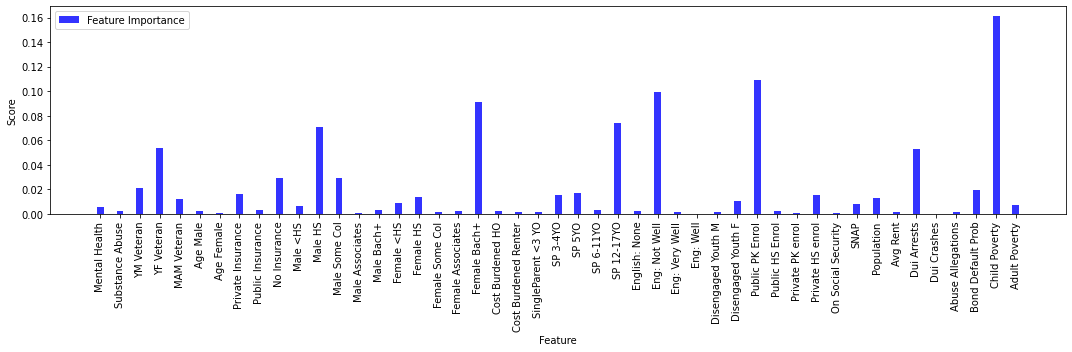

In [ ]:
n_groups=47
fig, ax = plt.subplots(figsize=(15,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
a=plt.bar(index, reg.feature_importances_, bar_width, alpha=opacity, color='b', label="Feature Importance", )
plt.xlabel('Feature')
plt.ylabel('Score')
plt.xticks(index, keys[0:47], rotation = 90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
d12=data2012.to_numpy(dtype=float, na_value=0)
x12=d12[0:170, 0:47]
y12=d12[0:170, 48]

d13=data2013.to_numpy(dtype=float, na_value=0)
x13=d13[0:170, 0:47]
y13=d13[0:170, 48]

d14=data2014.to_numpy(dtype=float, na_value=0)
x14=d14[0:170, 0:47]
y14=d14[0:170, 48]

d15=data2015.to_numpy(dtype=float, na_value=0)
x15=d15[0:170, 0:47]
y15=d15[0:170, 48]

d16=data2016.to_numpy(dtype=float, na_value=0)
x16=d16[0:170, 0:47]
y16=d16[0:170, 48]

d17=data2017.to_numpy(dtype=float, na_value=0)
x17=d17[0:170, 0:47]
y17=d17[0:170, 48]

d18=data2018.to_numpy(dtype=float, na_value=0)
x18=d18[0:170, 0:47]
y18=d18[0:170, 48]

d19=data2019.to_numpy(dtype=float, na_value=0)
x19=d19[0:170, 0:47]
y19=d19[0:170, 48]
